In [1]:
import time
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import numpy as np
import pydicom

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# 加载SPECT骨扫描数据

In [60]:
folder = r"C:\Users\haipw\Desktop\人工智能与医学影像\datasets"
import glob
import pydicom
filenames = glob.glob(f"{folder}/train/*.dcm")

In [69]:
print(filenames[3])
dcm = pydicom.dcmread(filenames[3])
# read pixel data
arr = dcm.pixel_array
print(arr.shape)
print(dcm.PatientSex)
# list all the dicom tags
for i in dcm.elements():
    if type(i) == pydicom.DataElement:
        print(i.description)
t = arr.flatten()
t.shape

C:\Users\haipw\Desktop\人工智能与医学影像\datasets/train\86066_20190218135718907.dcm
(2, 1024, 256)
F
<bound method DataElement.description of (0008, 0005) Specific Character Set              CS: ''>
<bound method DataElement.description of (0010, 0040) Patient's Sex                       CS: 'F'>
<bound method DataElement.description of (0010, 1030) Patient's Weight                    DS: None>
<bound method DataElement.description of (0018, 1242) Actual Frame Duration               IS: None>
<bound method DataElement.description of (0028, 0002) Samples per Pixel                   US: 1>
<bound method DataElement.description of (0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'>
<bound method DataElement.description of (0028, 0008) Number of Frames                    IS: '2'>
<bound method DataElement.description of (0028, 0010) Rows                                US: 1024>
<bound method DataElement.description of (0028, 0011) Columns                             US: 256>
<bound

(524288,)

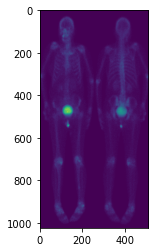

In [67]:
plt.imshow(np.concatenate([arr[0], arr[1]],axis = 1))

In [82]:
""" 
读取数据集
"""
def get_dataset(path:str):
    X = []
    y = []
    filenames = glob.glob(f"{path}/*.dcm")
    for path in filenames:
        ds = pydicom.dcmread(path)
        try:
            arr = ds.pixel_array
            if arr.shape[0] == 2 and arr.shape[1] == 1024:
                arr = np.concatenate([arr[0], arr[1]],axis = 1)
                arr = arr.flatten()
                X.append(arr)
                y.append(ds.PatientSex)
            else:
                print(arr.shape)
        except:
            print(path)
    X = np.stack(X)
    y = np.stack(y)
    return X,y

folder = r"C:\Users\haipw\Desktop\人工智能与医学影像\datasets"

X_train, y_train = get_dataset(folder + "/train")
X_test, y_test = get_dataset(folder + "/test")
print(X_train.shape, X_test.shape)

(2, 256, 256)
(256, 256)
(256, 256)
C:\Users\haipw\Desktop\人工智能与医学影像\datasets/train\90243_20190820150959432000.dcm
C:\Users\haipw\Desktop\人工智能与医学影像\datasets/train\90247_20190820145151365000.dcm
(659, 524288) (80, 524288)


In [83]:
#  归一化，数据清晰
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit to data then transform
X_test = scaler.transform(X_test)

In [84]:
train_samples = X_train.shape[0]

In [85]:
""" 训练 """
t0 = time.time()
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train) # 喂给
sparsity = np.mean(clf.coef_ == 0) * 100
acc = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test acc with L1 penalty: %.4f" % acc)
run_time = time.time() - t0
print(f"Example run in {run_time:.3f} s")

Sparsity with L1 penalty: 54.63%
Test score with L1 penalty: 0.8125
Example run in 55.238 s


In [103]:
clf.classes_

array(['F', 'M'], dtype='<U1')

In [96]:
predict = clf.predict_proba(X_test)
predict.shape

(80, 2)

In [104]:
from sklearn import metrics
# metrics.roc_auc_score(y_test, predict[:,0].squeeze())
y_true = ['F' == x for x in y_test]
metrics.roc_auc_score(y_true, predict[:,0].squeeze())

0.8910256410256411

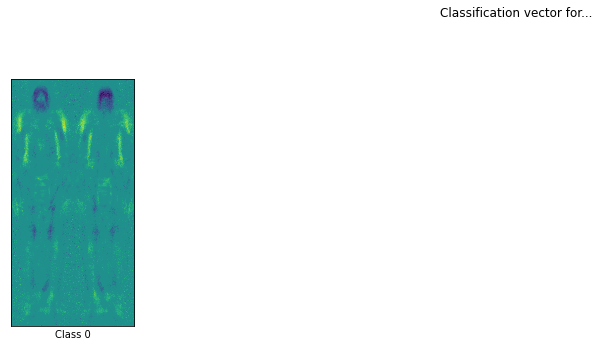

In [91]:
coef = clf.coef_.copy() # 复制模型参数
# print(coef)
plt.figure(figsize=(20, 10))
scale = np.abs(coef).max()
for i in range(1):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(1024, 512),
        interpolation="nearest",
        # cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")
plt.show()

In [ ]:
# 思考一下这个算法有没有什么问题？